Configuración e Importaciones

In [ ]:
# Celda 1: Importaciones
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import os
import joblib
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

# Celda 2: Carga del modelo de spacy y semilla
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
seed = 42

Carga y Preprocesamiento de Datos

In [2]:
# Celda 3: Carga del DataFrame
ruta_archivo = 'data/training.1600000.processed.noemoticon.csv'
try:
    df = pd.read_csv(ruta_archivo, encoding='latin-1', header=None)
    df.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    cols_to_drop = ['id', 'date', 'query', 'user']
    df = df.drop(columns=cols_to_drop)
    print(f"✅ DataFrame cargado con {len(df)} filas.")
except FileNotFoundError:
    print(f"Error: El archivo no fue encontrado en la ruta: {ruta_archivo}")

# Celda 4: Mapeo de Sentimientos
if 'df' in locals():
    df['Sentiment'] = df['Sentiment'].map({0: 'Negative', 4: 'Positive'})
    df_copy = df.copy() # Creamos una copia para visualizaciones
    print('Distribución de sentimientos:')
    print(df['Sentiment'].value_counts())

✅ DataFrame cargado con 1600000 filas.
Distribución de sentimientos:
Sentiment
Negative    800000
Positive    800000
Name: count, dtype: int64


Análisis Exploratorio de Datos (EDA)

Generando nubes de palabras...


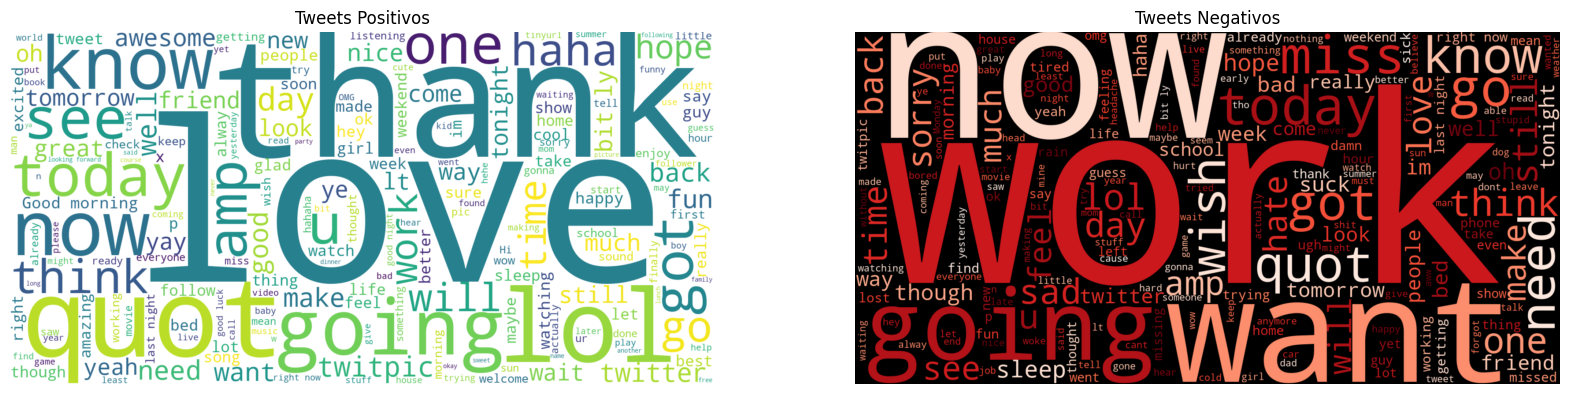

In [3]:
# Celda 5: Nube de Palabras
if 'df_copy' in locals():
    print("Generando nubes de palabras...")
    positive_tweets = df_copy[df_copy['Sentiment'] == 'Positive']['Text'].str.cat(sep=' ')
    negative_tweets = df_copy[df_copy['Sentiment'] == 'Negative']['Text'].str.cat(sep=' ')

    wordcloud_pos = WordCloud(width=1600, height=800, background_color='white').generate(positive_tweets)
    wordcloud_neg = WordCloud(width=1600, height=800, background_color='black', colormap='Reds').generate(negative_tweets)

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.title('Tweets Positivos')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.title('Tweets Negativos')
    plt.axis('off')
    plt.show()

Preparación para el Modelo | Se intenta cargar el split_data.joblib, si no lo logra se ejecuta la limpieza y se guarda.

In [ ]:

# --- Intenta cargar los datos preprocesados ---
try:
    ruta_archivo_joblib = 'data_processed/split_data.joblib'
    datos_cargados = joblib.load(ruta_archivo_joblib)
    X_train = datos_cargados['X_train']
    X_test = datos_cargados['X_test']
    y_train = datos_cargados['y_train']
    y_test = datos_cargados['y_test']
    print("✅ Datos preprocesados cargados exitosamente desde el archivo.")

# --- Si no los encuentra, ejecuta la limpieza y el guardado ---
except FileNotFoundError:
    print("⚠️ Archivo 'split_data.joblib' no encontrado. Ejecutando el preprocesamiento...")
    if 'df' in locals():
        # Función de limpieza (asegúrate de que esté definida previamente)
        def limpieza(texto):
            if not isinstance(texto, str):
                return ""
            texto = texto.lower()
            texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
            texto = re.sub(r'\s+', ' ', texto).strip()
            if not texto:
                return ""
            doc = nlp(texto)
            return ' '.join([token.lemma_ for token in doc if not token.is_stop])

        # Preparación y división de los datos
        X = df['Text'].apply(limpieza)
        y = df['Sentiment'].map({'Negative': -1, 'Positive': 1})

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

        # Guardado de los datos procesados
        output_dir = 'data_processed'
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, 'split_data.joblib')
        joblib.dump({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}, output_path)
        print(f"💾 Datos procesados y guardados en: '{output_path}'")
    else:
        print("❌ Error: El DataFrame 'df' no está definido. Asegúrate de cargarlo primero.")

✅ Datos preprocesados cargados exitosamente desde el archivo.


Entrenamiento y Evaluación del Modelo

Paso 1: Realizando vectorización TF-IDF optimizada...
Vectorización completada.

Paso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...
Mejores parámetros encontrados: {'C': 0.5}

--- Reporte de Clasificación (Test) ---
              precision    recall  f1-score   support

          -1       0.79      0.75      0.77    240000
           1       0.76      0.80      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000


Paso 3: Evaluando el mejor modelo encontrado...

--- Reporte de Clasificación (Train) ---
              precision    recall  f1-score   support

          -1       0.80      0.76      0.78    560000
           1       0.77      0.81      0.79    560000

    accuracy                           0.78   1120000
   macro avg       0.78      0.78      0.78   1120000
weighted avg       0.78      0.78      0.78   1120000


--- Reporte de Clasific

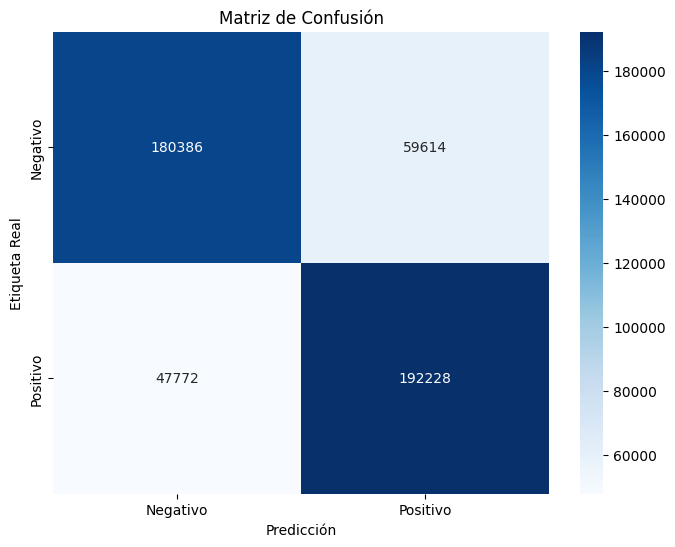


✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta 'model_robust'.


In [9]:
# Celda 8: Vectorización y Optimización del Modelo
print("Paso 1: Realizando vectorización TF-IDF optimizada...")
vectorizer_tfidf_opt = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, min_df=5, max_df=0.7)
X_train_tfidf_opt = vectorizer_tfidf_opt.fit_transform(X_train)
X_test_tfidf_opt = vectorizer_tfidf_opt.transform(X_test)
print("Vectorización completada.")

print("\nPaso 2: Iniciando búsqueda de hiperparámetros con GridSearchCV...")
model_lr = LogisticRegression(random_state=seed, max_iter=1000)
param_grid = {'C': [0.1, 0.5, 1]}
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_tfidf_opt, y_train)
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Celda 9: Evaluación del Mejor Modelo
best_model_lr = grid_search.best_estimator_
y_test_pred = best_model_lr.predict(X_test_tfidf_opt)

print("\n--- Reporte de Clasificación (Test) ---")
print(classification_report(y_test, y_test_pred))

# --- 3. Evaluando el mejor modelo encontrado ---
print("\nPaso 3: Evaluando el mejor modelo encontrado...")

# 'best_estimator_' es el modelo ya entrenado con el mejor 'C'
best_model_lr = grid_search.best_estimator_

# --- Reporte de Clasificación (Train) ---
print("\n--- Reporte de Clasificación (Train) ---")
y_train_pred = best_model_lr.predict(X_train_tfidf_opt)
print(classification_report(y_train, y_train_pred))

# --- Reporte de Clasificación (Test) ---
print("\n--- Reporte de Clasificación (Test) ---")
y_test_pred = best_model_lr.predict(X_test_tfidf_opt)
print(classification_report(y_test, y_test_pred))

# Celda 10: Matriz de Confusión
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# Celda 11: Guardado del Modelo y Vectorizador Final
output_dir = 'model_robust'
os.makedirs(output_dir, exist_ok=True)
joblib.dump(vectorizer_tfidf_opt, os.path.join(output_dir, 'schimizzi_vectorizer_final.joblib'))
joblib.dump(best_model_lr, os.path.join(output_dir, 'schimizzi_modelo_final.joblib'))
print(f"\n✅ ¡Éxito! Modelo y vectorizador guardados en la carpeta '{output_dir}'.")


Uso del Modelo Guardado para Predicciones

In [ ]:

# --- 1. Cargar el modelo de lenguaje de Spacy ---
# Esto es necesario para que la función 'limpieza' funcione.
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print('Descargando el modelo en_core_web_sm de spaCy...')
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# --- 2. Definir la función de limpieza ---
# Esta debe ser la misma función que usaste para entrenar el modelo.
def limpieza(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    if not texto:
        return ""
    doc = nlp(texto)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

# --- 3. Cargar el modelo y el vectorizador guardados ---
try:
    vectorizer_cargado = joblib.load('model_robust/schimizzi_vectorizer_final.joblib')
    modelo_cargado = joblib.load('model_robust/schimizzi_modelo_final.joblib')
    print("Vectorizer y modelo cargados correctamente.\n")

    # --- 4. Preparar y predecir sobre datos nuevos ---
    df_nuevos = pd.read_csv('data/testdata.manual.2009.06.14.csv', header=None, encoding='latin-1')
    df_nuevos.columns = ['Sentiment', 'id', 'date', 'query', 'user', 'Text']
    
    # Aplicar la limpieza a los nuevos datos
    nuevos_datos_limpios = df_nuevos['Text'].apply(limpieza)
    
    # Transformar los datos limpios con el vectorizador cargado
    nuevos_datos_tfidf = vectorizer_cargado.transform(nuevos_datos_limpios)
    
    # Realizar la predicción
    predicciones = modelo_cargado.predict(nuevos_datos_tfidf)
    
    # Mostrar resultados
    mapa_sentimiento = {-1: "Negativo", 1: "Positivo"}
    df_nuevos['Prediccion'] = [mapa_sentimiento[p] for p in predicciones]
    
    print("--- Muestra de Predicciones sobre Datos Nuevos ---")
    print(df_nuevos[['Text', 'Prediccion']].head(20))

except FileNotFoundError:
    print("\nError: Asegúrate de que los archivos 'schimizzi_vectorizer_final.joblib' y 'schimizzi_modelo_final.joblib' estén en la carpeta 'model_robust'.")

Vectorizer y modelo cargados correctamente.

--- Muestra de Predicciones sobre Datos Nuevos ---
                                                 Text Prediccion
0   @stellargirl I loooooooovvvvvveee my Kindle2. ...   Positivo
1   Reading my kindle2...  Love it... Lee childs i...   Positivo
2   Ok, first assesment of the #kindle2 ...it fuck...   Positivo
3   @kenburbary You'll love your Kindle2. I've had...   Positivo
4   @mikefish  Fair enough. But i have the Kindle2...   Positivo
5   @richardebaker no. it is too big. I'm quite ha...   Positivo
6   Fuck this economy. I hate aig and their non lo...   Negativo
7                       Jquery is my new best friend.   Positivo
8                                       Loves twitter   Positivo
9   how can you not love Obama? he makes jokes abo...   Positivo
10  Check this video out -- President Obama at the...   Positivo
11  @Karoli I firmly believe that Obama/Pelosi hav...   Negativo
12  House Correspondents dinner was last night who...   Pos